# Analysis of ATLAS-GAN results

Let's take a look at the results of the DCGAN trained to generate ATLAS RPV SUSY events.

In [1]:
# Convenient fudge for python path
import sys
sys.path.append('..')

In [2]:
# System
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os

# Externals
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.autograd import Variable

# Locals
from atlasgan import reco, gan
from atlasgan.dataset import RPVImages, inverse_transform_data, generate_noise

%matplotlib notebook

In [3]:
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

## Load training results

In [4]:
results_dir = '/data0/sfarrell/atlas_gan/AtlasDCGAN_002'

In [5]:
ls $results_dir

checkpoints/  out.log  README  summaries.npz


In [6]:
# Load the summary data
summaries = np.load(os.path.join(results_dir, 'summaries.npz'))
print(summaries.keys())

['dis_output_fake', 'gen_samples', 'dis_output_real', 'epoch', 'gen_loss', 'dis_loss']


<IPython.core.display.Javascript object>


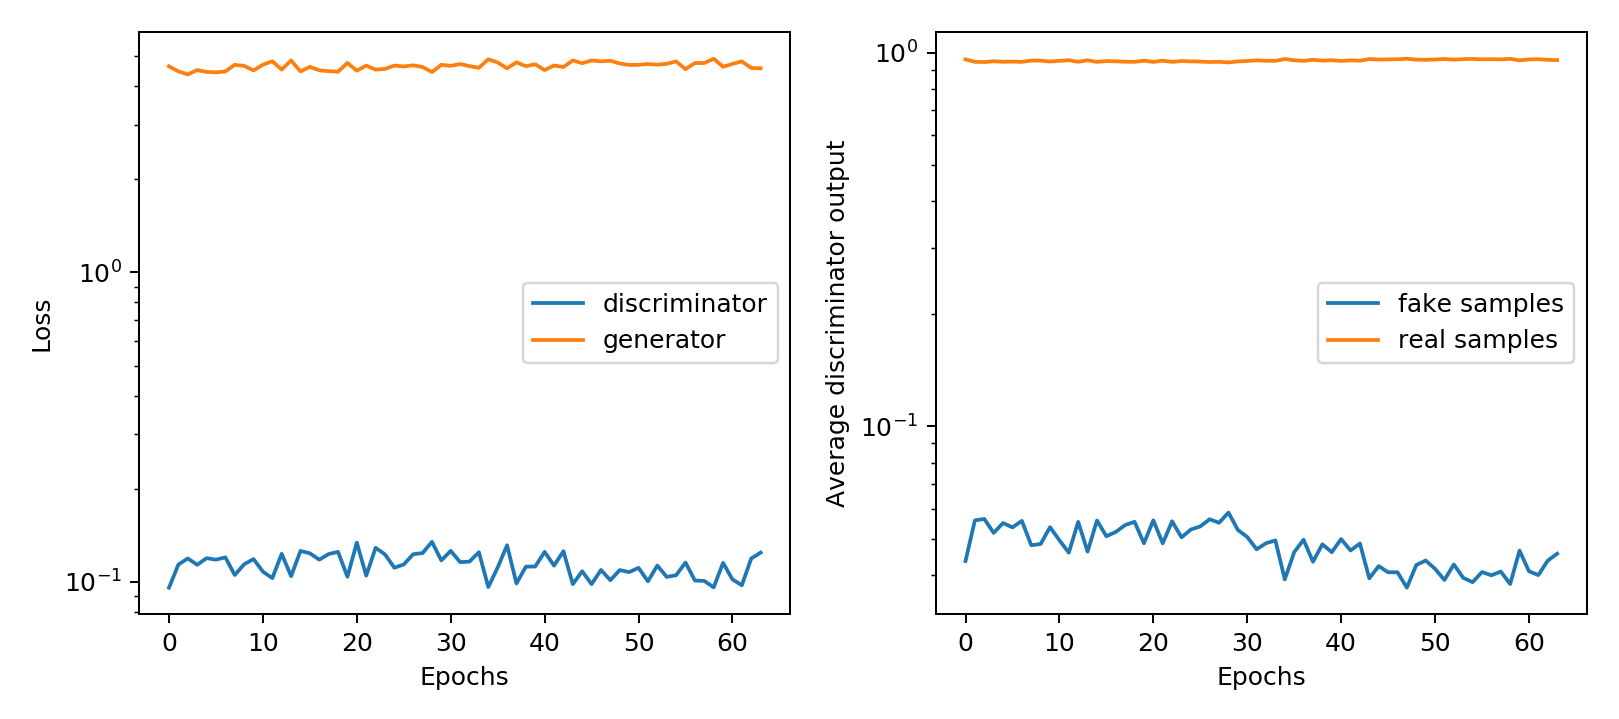

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))

# Plot training loss
ax0.semilogy(summaries['dis_loss'], label='discriminator')
ax0.semilogy(summaries['gen_loss'], label='generator')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

# Plot average discriminator outputs
ax1.semilogy(summaries['dis_output_fake'], label='fake samples')
ax1.semilogy(summaries['dis_output_real'], label='real samples')
ax1.legend(loc=0)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Average discriminator output')
plt.tight_layout()

## Loading checkpoints

In [8]:
def load_model(results_dir, checkpoint_id, noise_dim=64):
    """Load generator and discriminator from checkpoint"""
    checkpoint_file = os.path.join(
        results_dir, 'checkpoints', 'model_checkpoint_%03i.pth.tar' % checkpoint_id
    )
    checkpoint = torch.load(checkpoint_file)
    generator = gan.Generator(noise_dim)
    discriminator = gan.Discriminator()
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    return generator, discriminator

In [9]:
noise_dim = 64
generator, discriminator = load_model(results_dir, checkpoint_id=63, noise_dim=noise_dim)

generator.eval(), discriminator.eval();

## Load test data
We don't currently have a separate validation and test dataset, so for now we will do the model selection here on a test dataset.

In [10]:
input_data = '/data0/sfarrell/atlas_rpv_data/RPV10_1400_850_01.npz'

scale = 6072947 #FIXME
threshold = 500
n_samples = 4096

In [11]:
dataset = RPVImages(input_data, n_samples=n_samples, scale=scale, from_back=True)

## Test models on test data

In [12]:
# Real images
test_real = Variable(dataset.data, volatile=True)
# Random noise; input for generator
test_noise = Variable(generate_noise(n_samples, noise_dim), volatile=True)

In [13]:
# Generated images
test_fake = generator(test_noise)

# Apply discriminator to real and fake samples
test_dis_real = discriminator(test_real)
test_dis_fake = discriminator(test_fake)

In [14]:
test_dis_real.mean(), test_dis_fake.mean()

(Variable containing:
  0.9492
 [torch.FloatTensor of size 1], Variable containing:
  0.1880
 [torch.FloatTensor of size 1])

## Visualize some samples

In [15]:
test_images = inverse_transform_data(dataset.data.numpy().squeeze(1), scale, threshold)
gen_images = inverse_transform_data(test_fake.data.numpy().squeeze(1), scale, threshold)

In [16]:
gen_images.shape, test_images.shape

((4096, 64, 64), (4096, 64, 64))

<IPython.core.display.Javascript object>


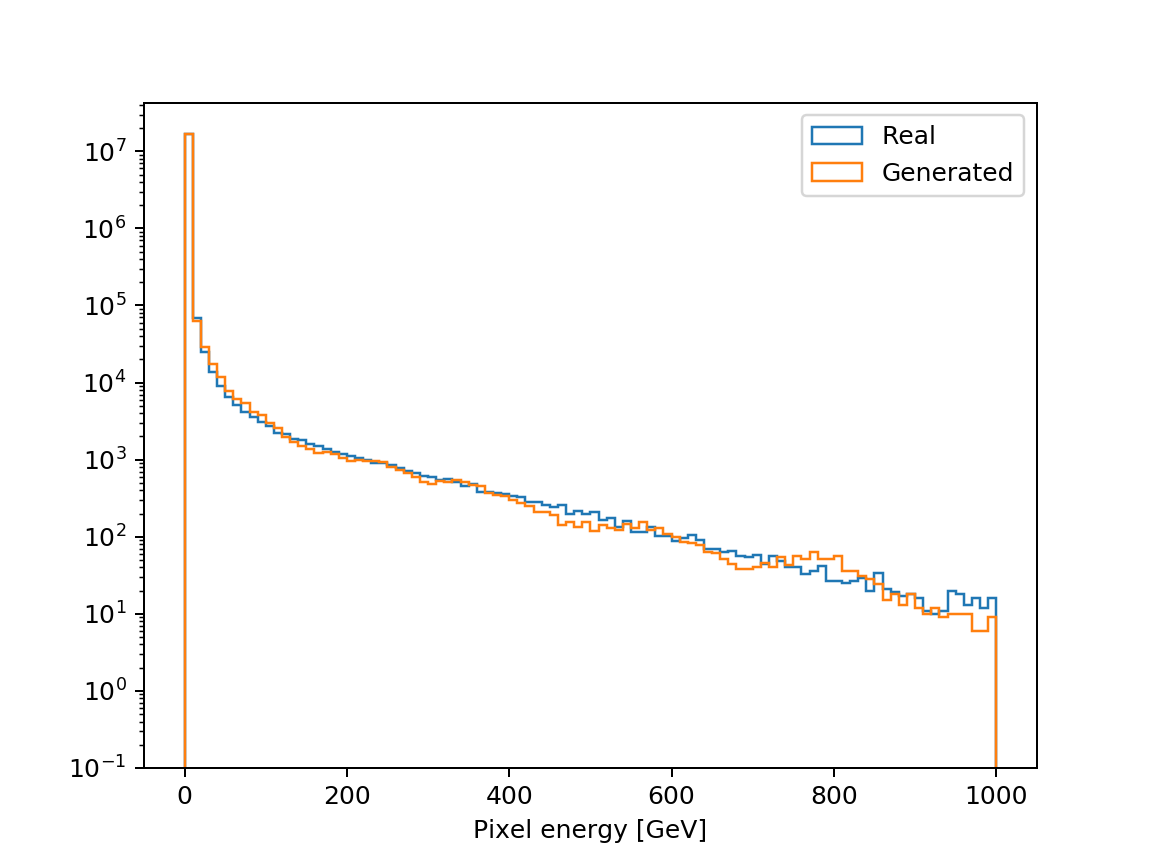

In [17]:
# Compare pixel intensity
plt.figure()
hist_args = dict(bins=100, range=(0, 1e3), log=True, histtype='step')
plt.hist(test_images.flatten()*1e-3, label='Real', **hist_args)
plt.hist(gen_images.flatten()*1e-3, label='Generated', **hist_args)
plt.xlabel('Pixel energy [GeV]')
plt.legend(loc=0)

<IPython.core.display.Javascript object>


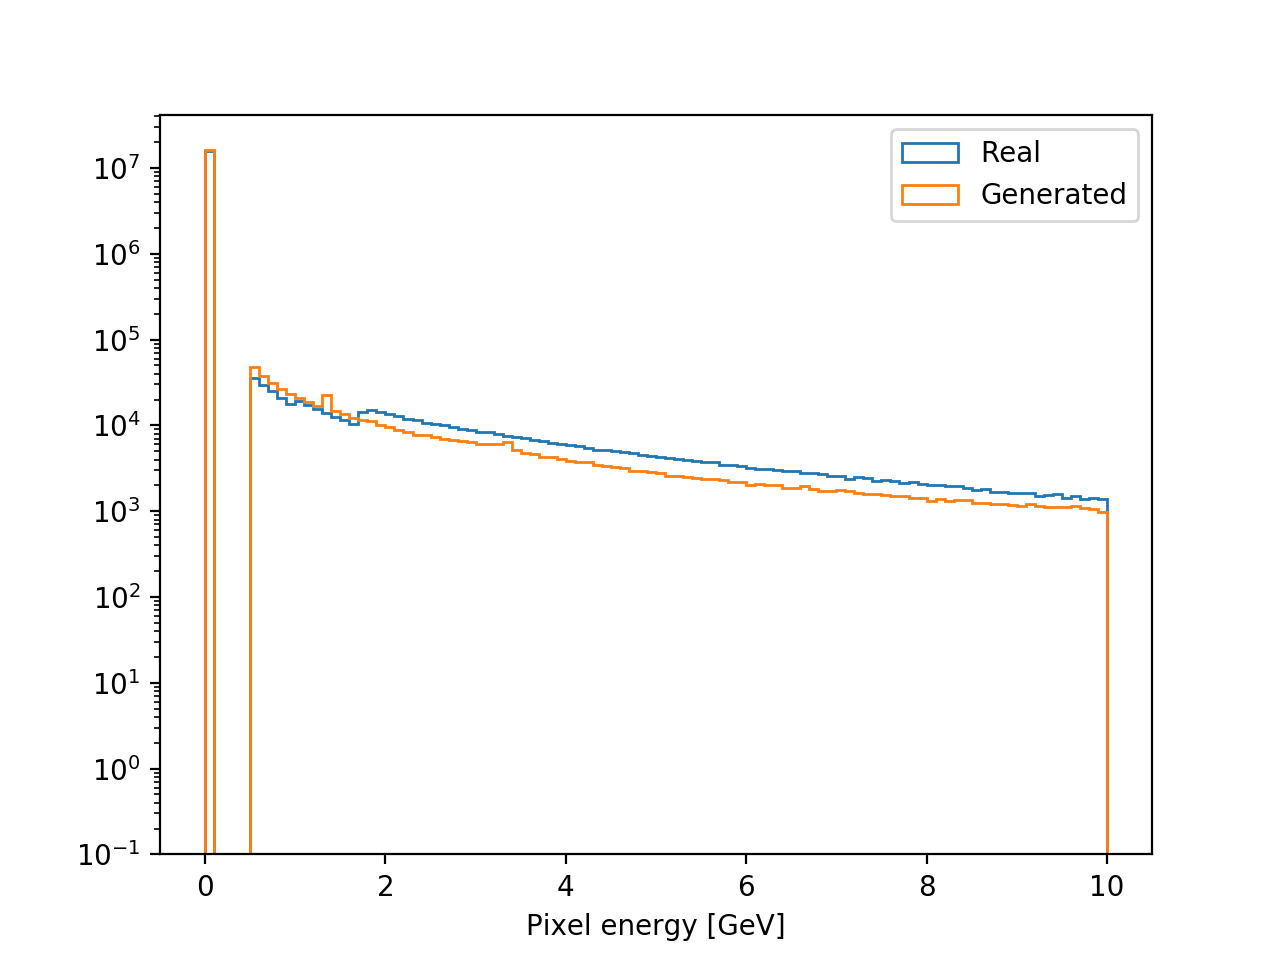

In [32]:
# Compare pixel intensity
plt.figure()
hist_args = dict(bins=100, range=(0, 10), log=True, histtype='step')
plt.hist(test_images.flatten()*1e-3, label='Real', **hist_args)
plt.hist(gen_images.flatten()*1e-3, label='Generated', **hist_args)
plt.xlabel('Pixel energy [GeV]')
plt.legend(loc=0)

<IPython.core.display.Javascript object>


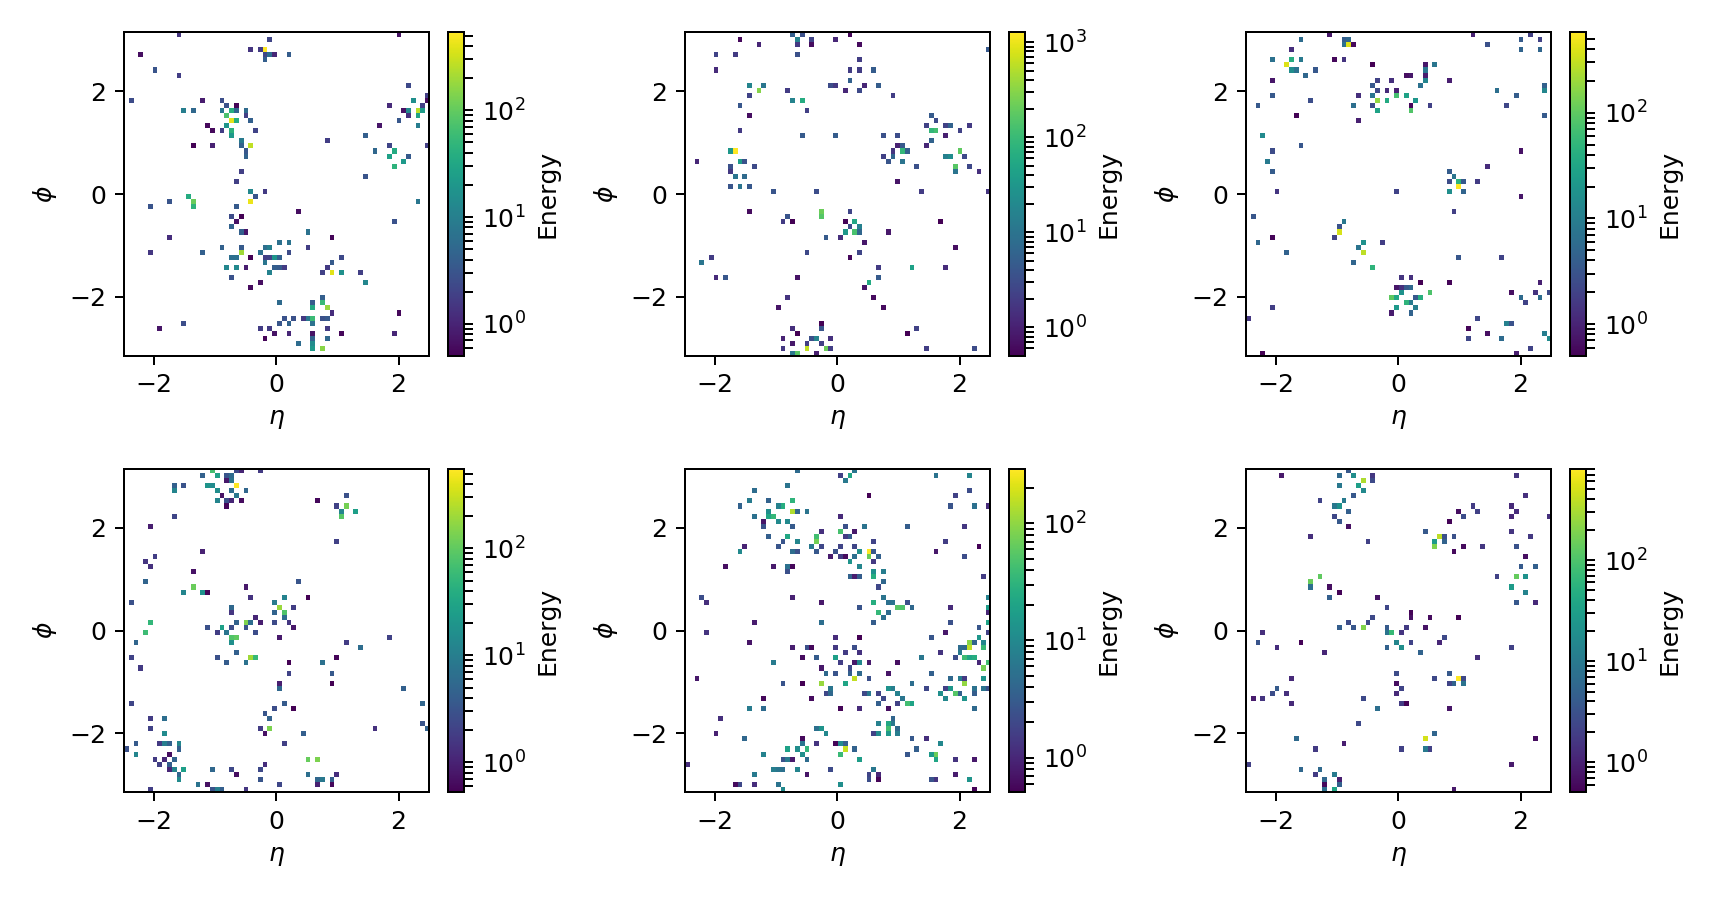

In [18]:
# Real images
fig, axs = plt.subplots(2, 3, figsize=(9.5, 5))
for i, ax in enumerate(axs.flatten()):
    draw_image(test_images[i]*1e-3, ax=ax)
plt.tight_layout()

<IPython.core.display.Javascript object>


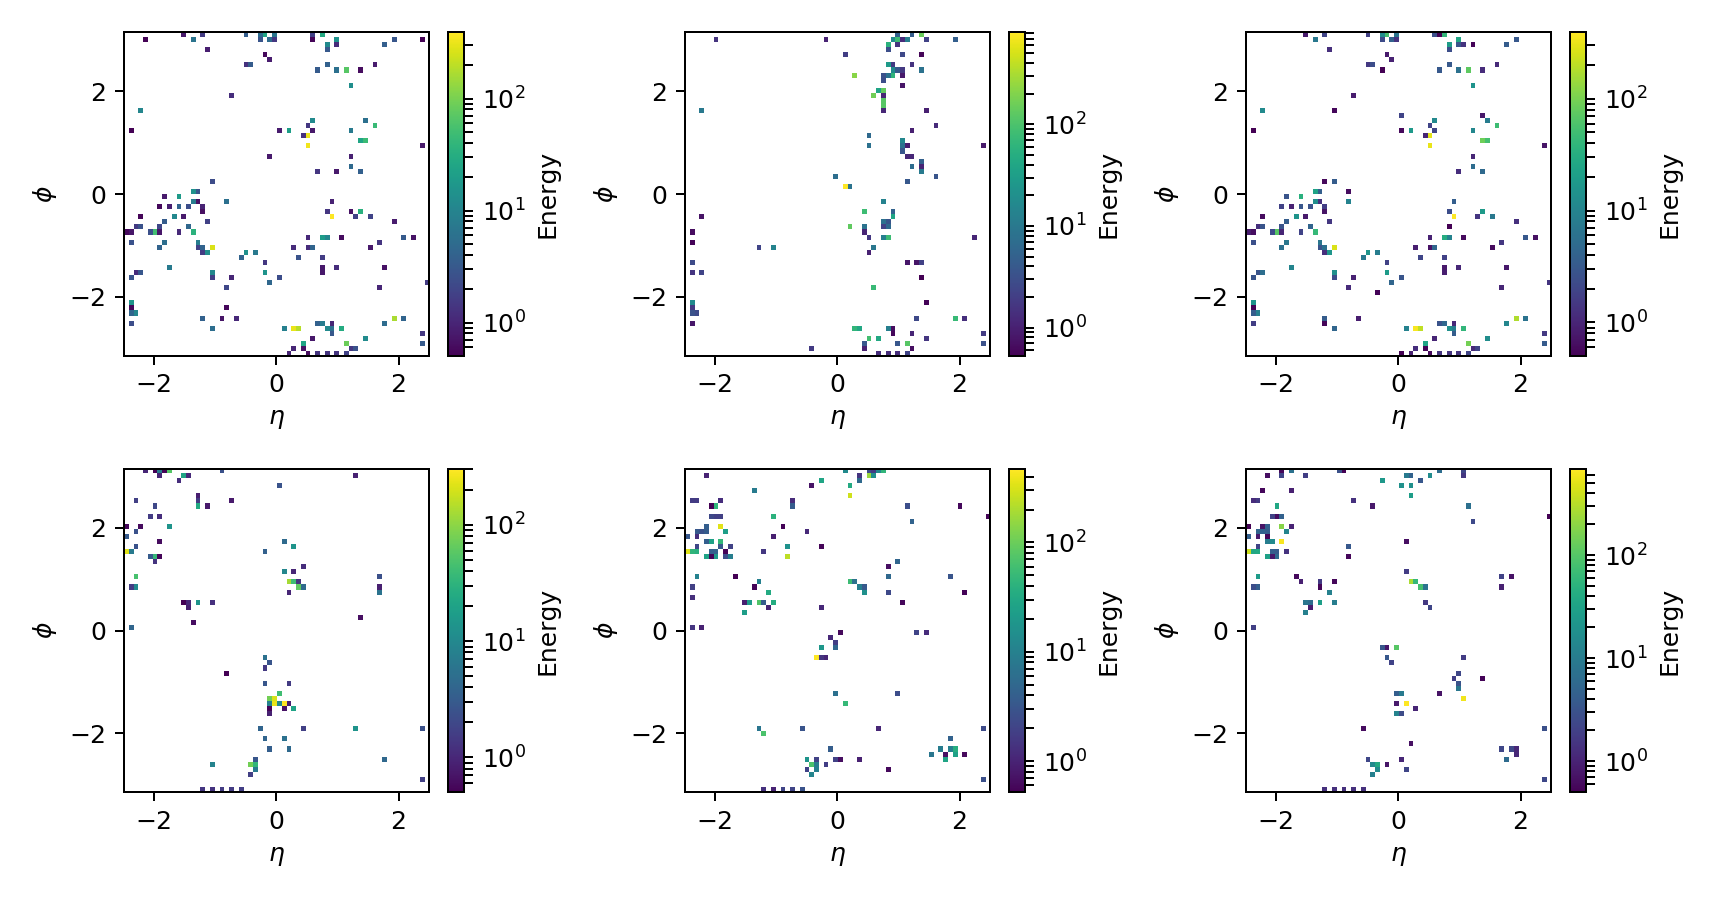

In [19]:
# Fake images
fig, axs = plt.subplots(2, 3, figsize=(9.5, 5))
for i, ax in enumerate(axs.flatten()):
    draw_image(gen_images[i]*1e-3, ax=ax)
plt.tight_layout()

## Plot physics distributions

In [20]:
def plot_physics(real_pixels, fake_pixels,
                 real_nJet, fake_nJet,
                 real_sumMass, fake_sumMass,
                 real_pt, fake_pt,
                 real_eta, fake_eta,
                 real_phi, fake_phi,
                 figsize=(9, 6), linewidth=1):
    
    fig1, axs = plt.subplots(2, 3, figsize=(9, 6))
    (ax0, ax1, ax2), (ax3, ax4, ax5) = axs
    
    # Pixel energy
    hist_args = dict(bins=100, range=(0, 1e3), log=True, histtype='step', linewidth=linewidth)
    ax0.hist(real_pixels.flatten()*1e-3, label='real', **hist_args)
    ax0.hist(fake_pixels.flatten()*1e-3, label='fake', **hist_args)
    ax0.set_xlabel('Pixel energy [GeV]')
    ax0.legend(loc=0)
    
    # Jet multiplicity
    hist_args = dict(bins=10, range=(0, 10), log=False, histtype='step', linewidth=linewidth)
    ax1.hist(real_nJet, label='real', **hist_args)
    ax1.hist(fake_nJet, label='fake', **hist_args)
    ax1.set_xlabel('Number of jets')
    ax1.legend(loc=0)

    # Sum of jet mass
    hist_args = dict(bins=20, range=(0, 2e3), log=False, histtype='step', linewidth=linewidth)
    ax2.hist(real_sumMass*1e-3, label='real', **hist_args)
    ax2.hist(fake_sumMass*1e-3, label='fake', **hist_args)
    ax2.set_xlabel('Sum of jet mass [GeV]')
    ax2.legend(loc=0)
    
    # Jet PT
    hist_args = dict(bins=20, range=(0, 2e3), histtype='step', linewidth=linewidth, log=False)
    ax3.hist(real_pt*1e-3, label='real', **hist_args)
    ax3.hist(fake_pt*1e-3, label='fake', **hist_args)
    ax3.set_xlabel('Jet $p_T$ [GeV]')
    ax3.legend(loc=0)

    # Jet eta
    hist_args = dict(bins=20, range=(-2, 2), histtype='step', linewidth=linewidth)
    ax4.hist(real_eta, label='real', **hist_args)
    ax4.hist(fake_eta, label='fake', **hist_args)
    ax4.set_xlabel('Jet $\eta$')
    ax4.legend(loc=0)

    # Jet phi
    hist_args = dict(bins=20, range=(-np.pi, np.pi), histtype='step', linewidth=linewidth)
    ax5.hist(real_phi, label='real', **hist_args)
    ax5.hist(fake_phi, label='fake', **hist_args)
    ax5.set_xlabel('Jet $\phi$')
    ax5.legend(loc=0)

    plt.tight_layout()

## Compute metrics for every epoch

Loop over epochs, load the checkpoint, generate the samples, compute the metrics.

Oh, but compute the real sample stuff first, of course!

In [21]:
from datetime import datetime

In [22]:
import scipy.stats

In [23]:
from atlasgan.reco import compute_physics_variables

In [ ]:
# Compute reconstructed physics variables from real images
real_reco_vars = compute_physics_variables(test_images)

In [ ]:
%%time

# Initially store all results in an epoch list
results = []

# Loop over epoch checkpoints
n_epochs = 64
for i in range(n_epochs):
    print(str(datetime.now()), 'Epoch', i)
    
    # Dictionary of results for this epoch
    epoch_results = {}
    epoch_results['epoch'] = i
    
    # Load the model
    generator, discriminator = load_model(results_dir, checkpoint_id=i, noise_dim=noise_dim)
    generator.eval(), discriminator.eval()
    
    # Generated images
    test_fake = generator(test_noise)
    gen_images = inverse_transform_data(test_fake.data.numpy().squeeze(1), scale, threshold)
    epoch_results['gen_images'] = gen_images

    # Apply discriminator to real and fake samples
    dis_real = discriminator(test_real)
    dis_fake = discriminator(test_fake)

    # Save the average discriminator scores
    epoch_results['dis_real'] = dis_real.mean().data[0]
    epoch_results['dis_fake'] = dis_fake.mean().data[0]

    # Compute physics variables on the generated images
    fake_reco_vars = compute_physics_variables(gen_images)
    epoch_results.update(fake_reco_vars)
    
    # Compute KS metrics
    for key in fake_reco_vars.keys():
        ks, pval = scipy.stats.ks_2samp(real_reco_vars[key], fake_reco_vars[key])
        epoch_results['ks_' + key] = pval
    
    results.append(epoch_results)

2018-06-11 11:50:31.999373 Epoch 0
2018-06-11 11:50:42.048461 Epoch 1
2018-06-11 11:50:52.389555 Epoch 2
2018-06-11 11:51:02.795913 Epoch 3
2018-06-11 11:51:13.757474 Epoch 4
2018-06-11 11:51:25.463050 Epoch 5
2018-06-11 11:51:37.556892 Epoch 6
2018-06-11 11:51:49.899128 Epoch 7
2018-06-11 11:52:01.923226 Epoch 8


In [ ]:
# Pack final results into one dict of arrays
final_results = {}
for key in results[0].keys():
    final_results[key] = np.array([r[key] for r in results])

<IPython.core.display.Javascript object>


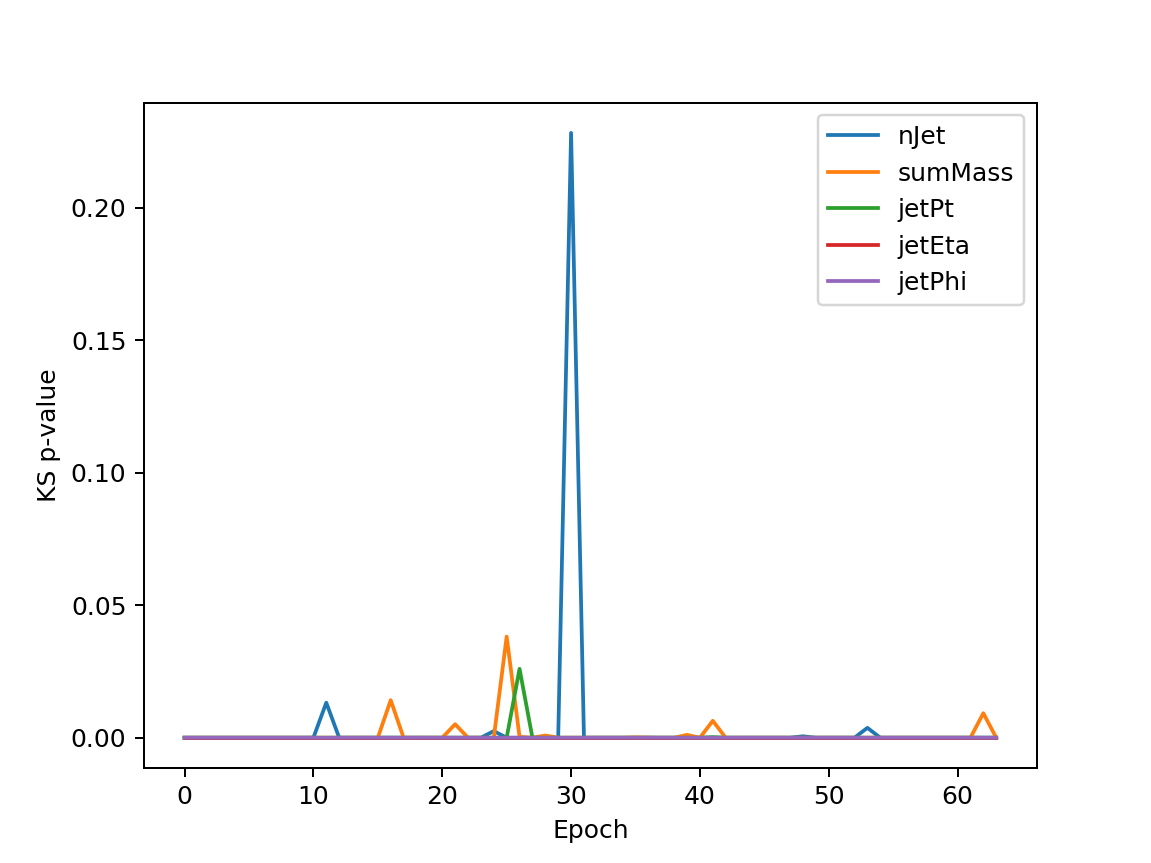

In [27]:
# Plot the physics variable metrics
plt.figure()

plt.plot(final_results['ks_nJet'], label='nJet')
plt.plot(final_results['ks_sumMass'], label='sumMass')
plt.plot(final_results['ks_jetPt'], label='jetPt')
plt.plot(final_results['ks_jetEta'], label='jetEta')
plt.plot(final_results['ks_jetPhi'], label='jetPhi')
plt.xlabel('Epoch')
plt.ylabel('KS p-value')
#plt.yscale('log')
#plt.ylim((1e-10, 1))
plt.legend(loc=0);

In [28]:
final_results['ks_jetPt'][41]

0.00022307114661617466

## Plot kinematics for select epochs

Epoch 0


<IPython.core.display.Javascript object>


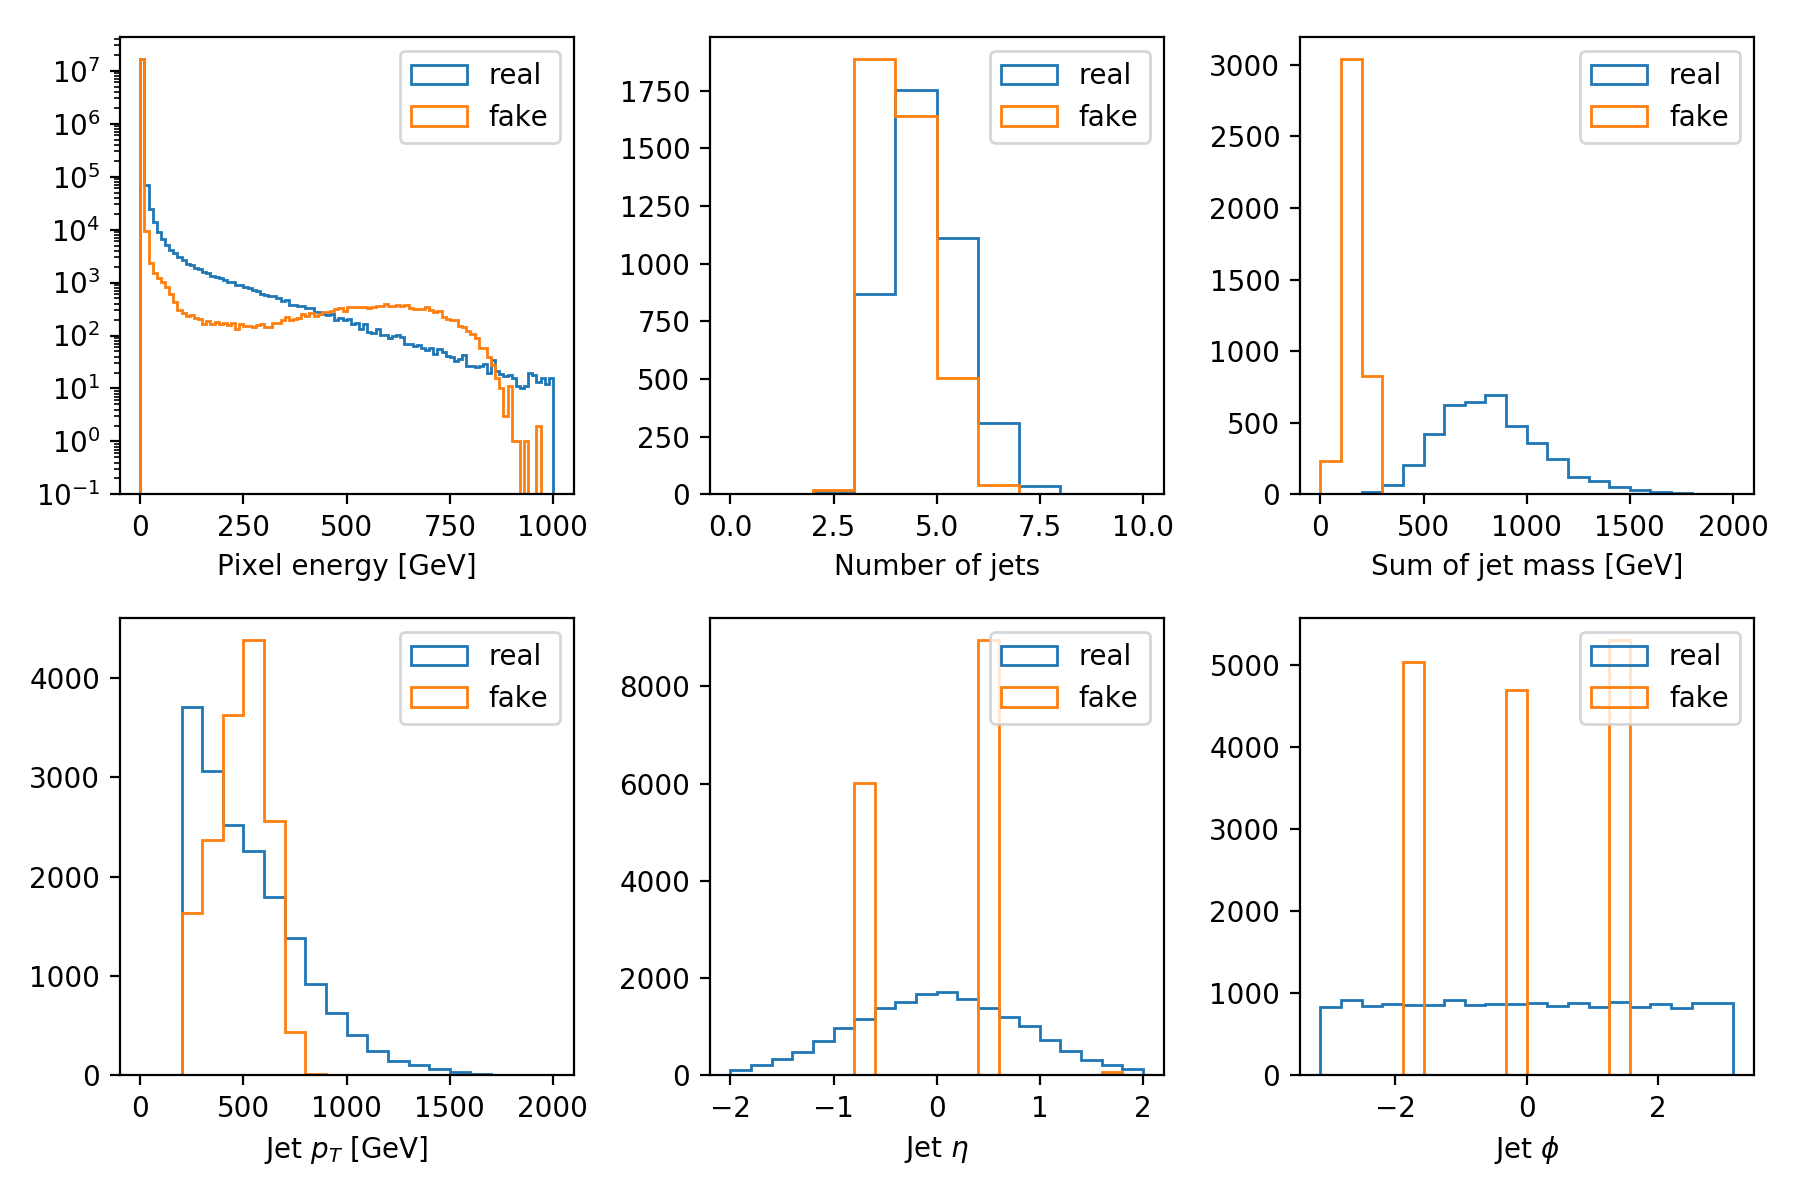

Epoch 1


<IPython.core.display.Javascript object>


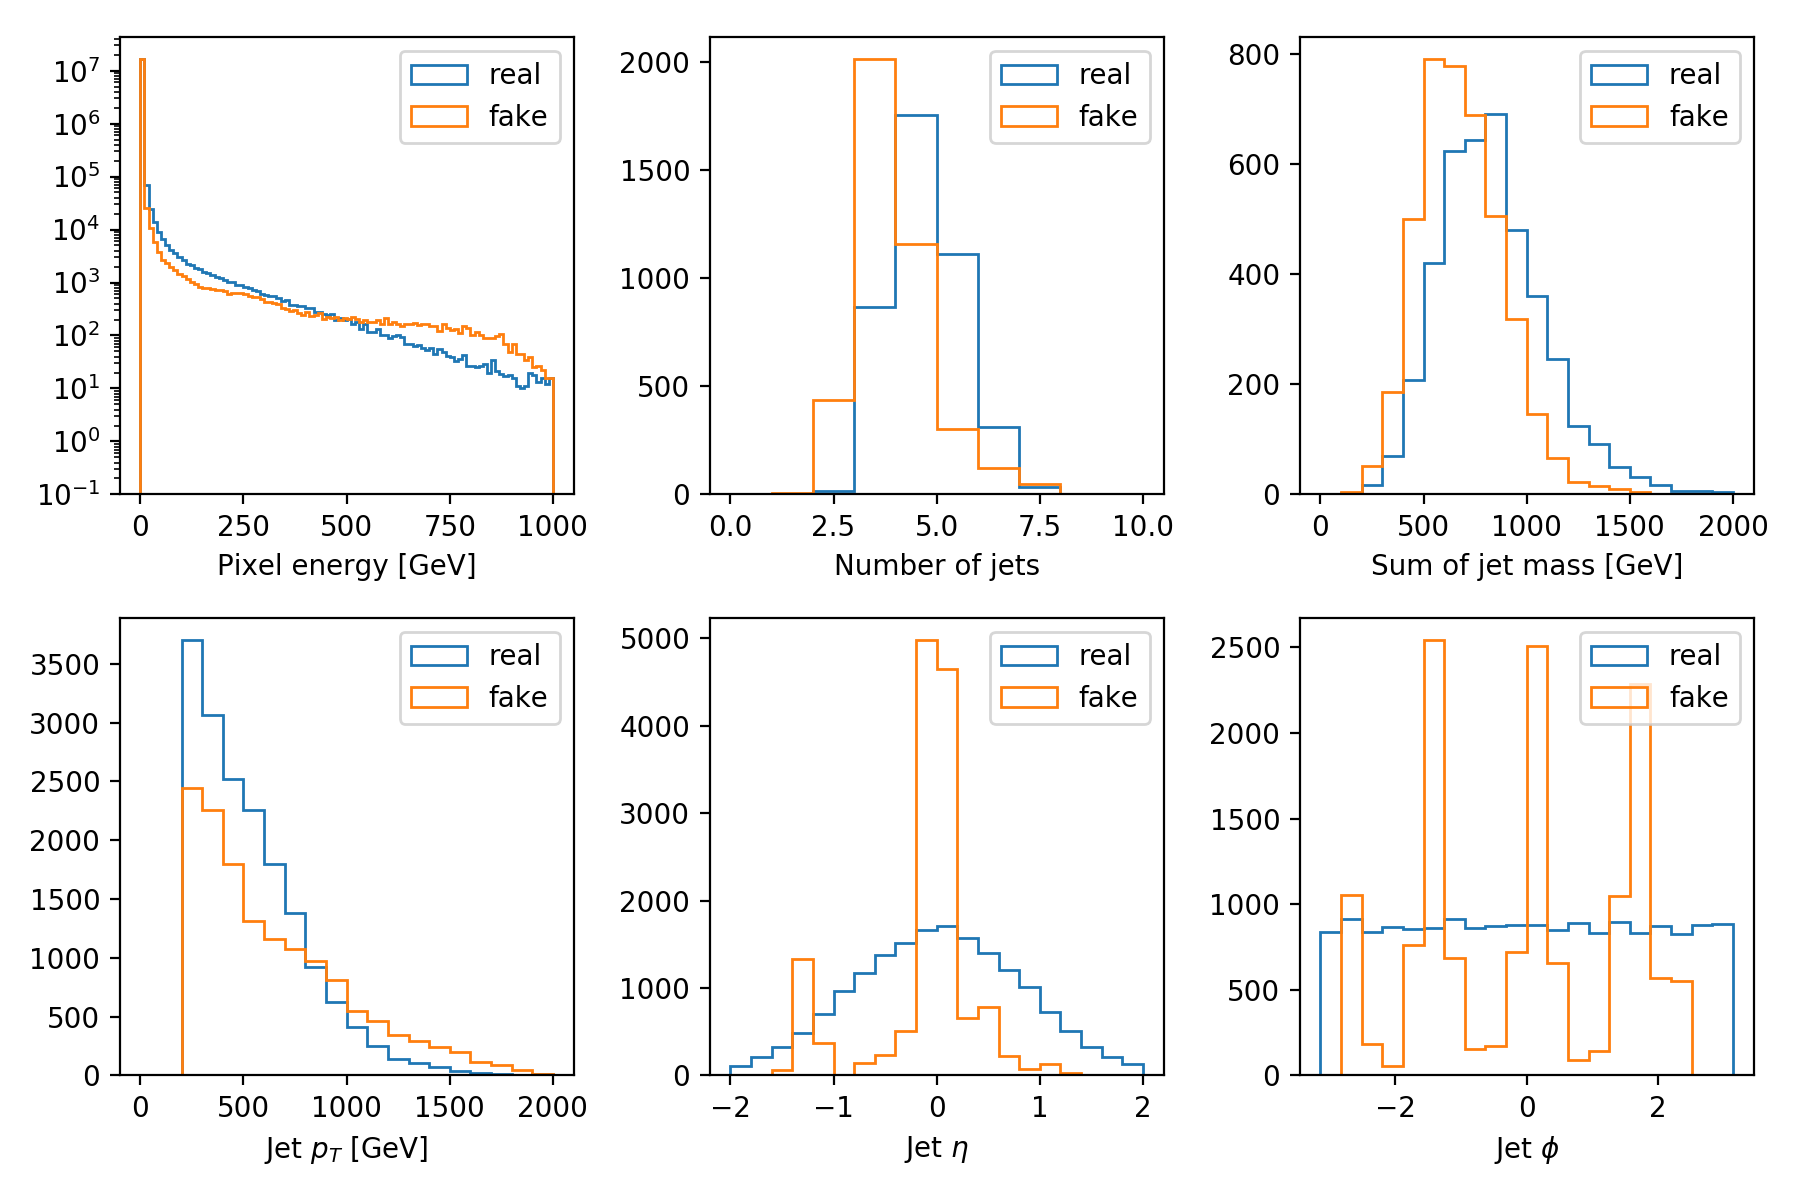

Epoch 2


<IPython.core.display.Javascript object>


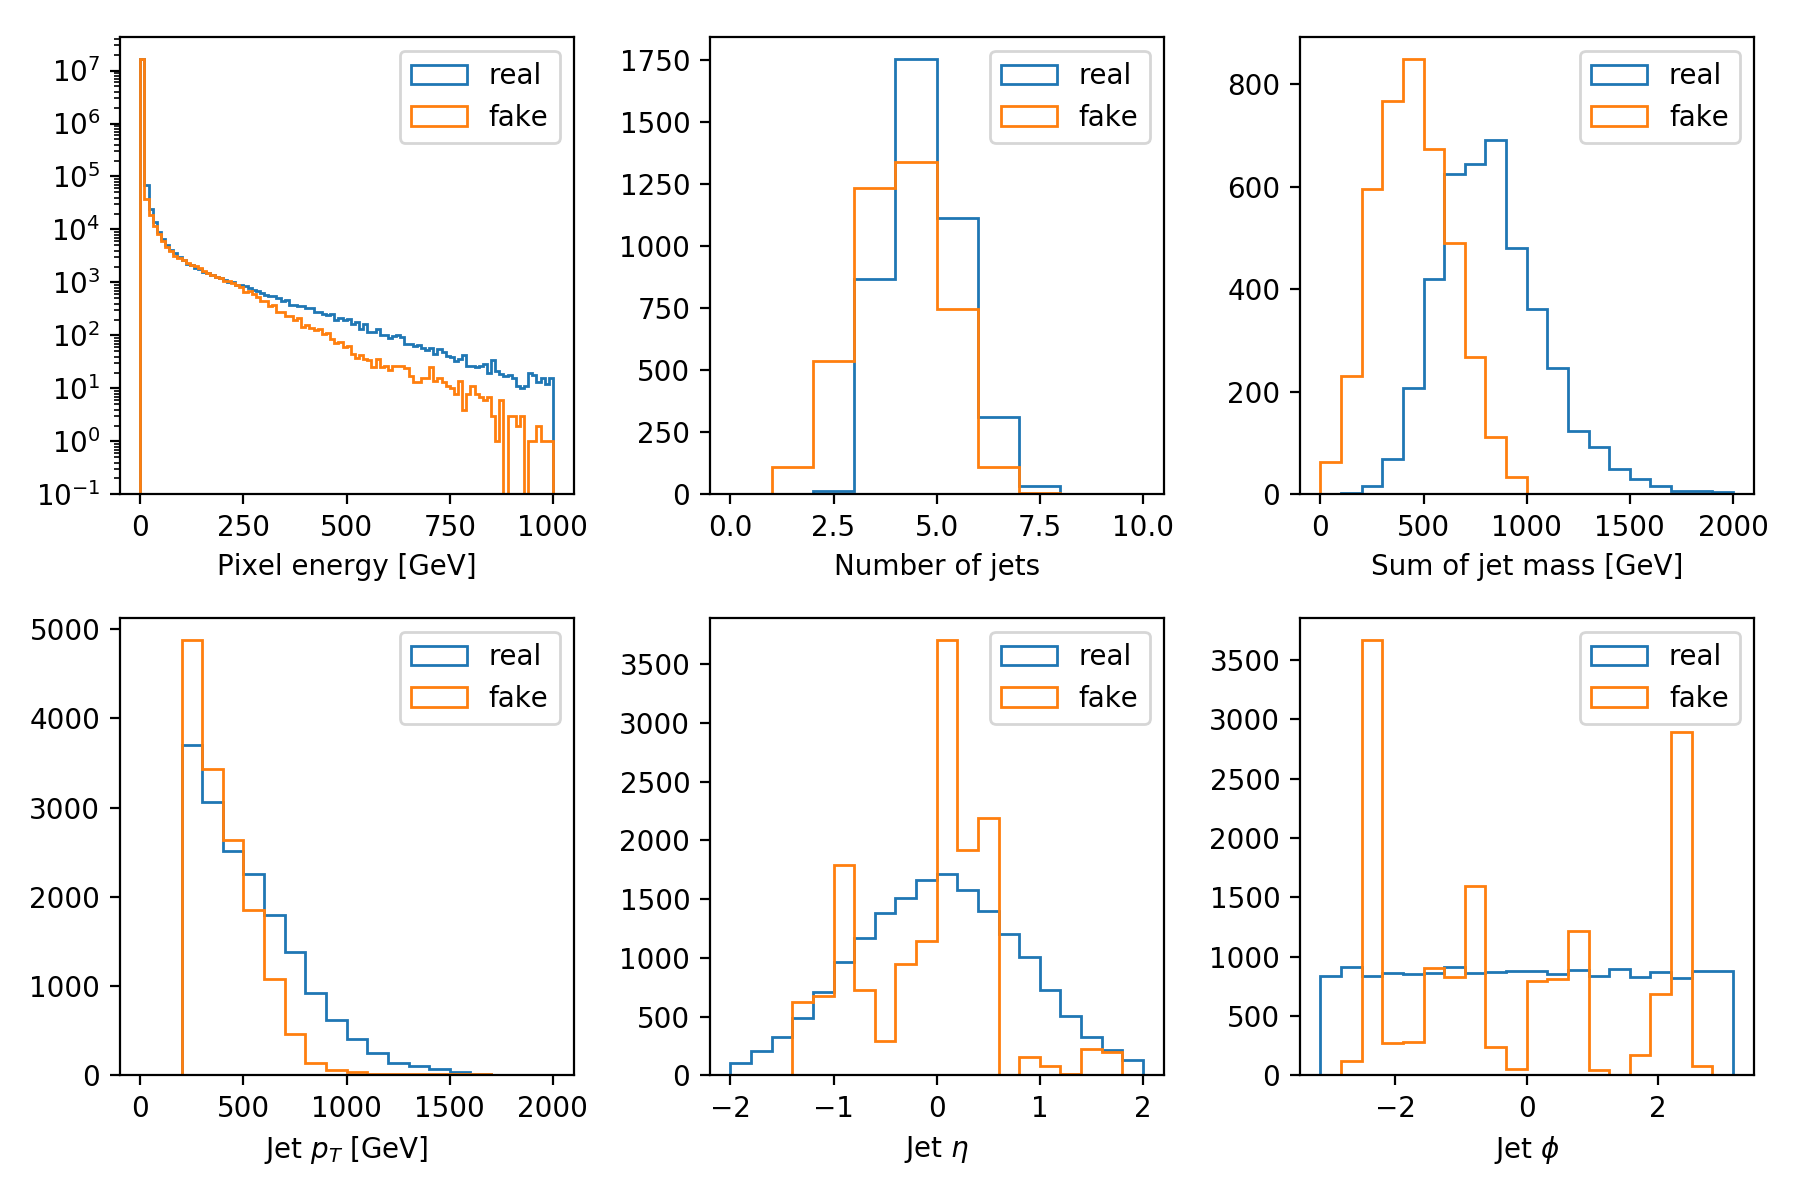

Epoch 7


<IPython.core.display.Javascript object>


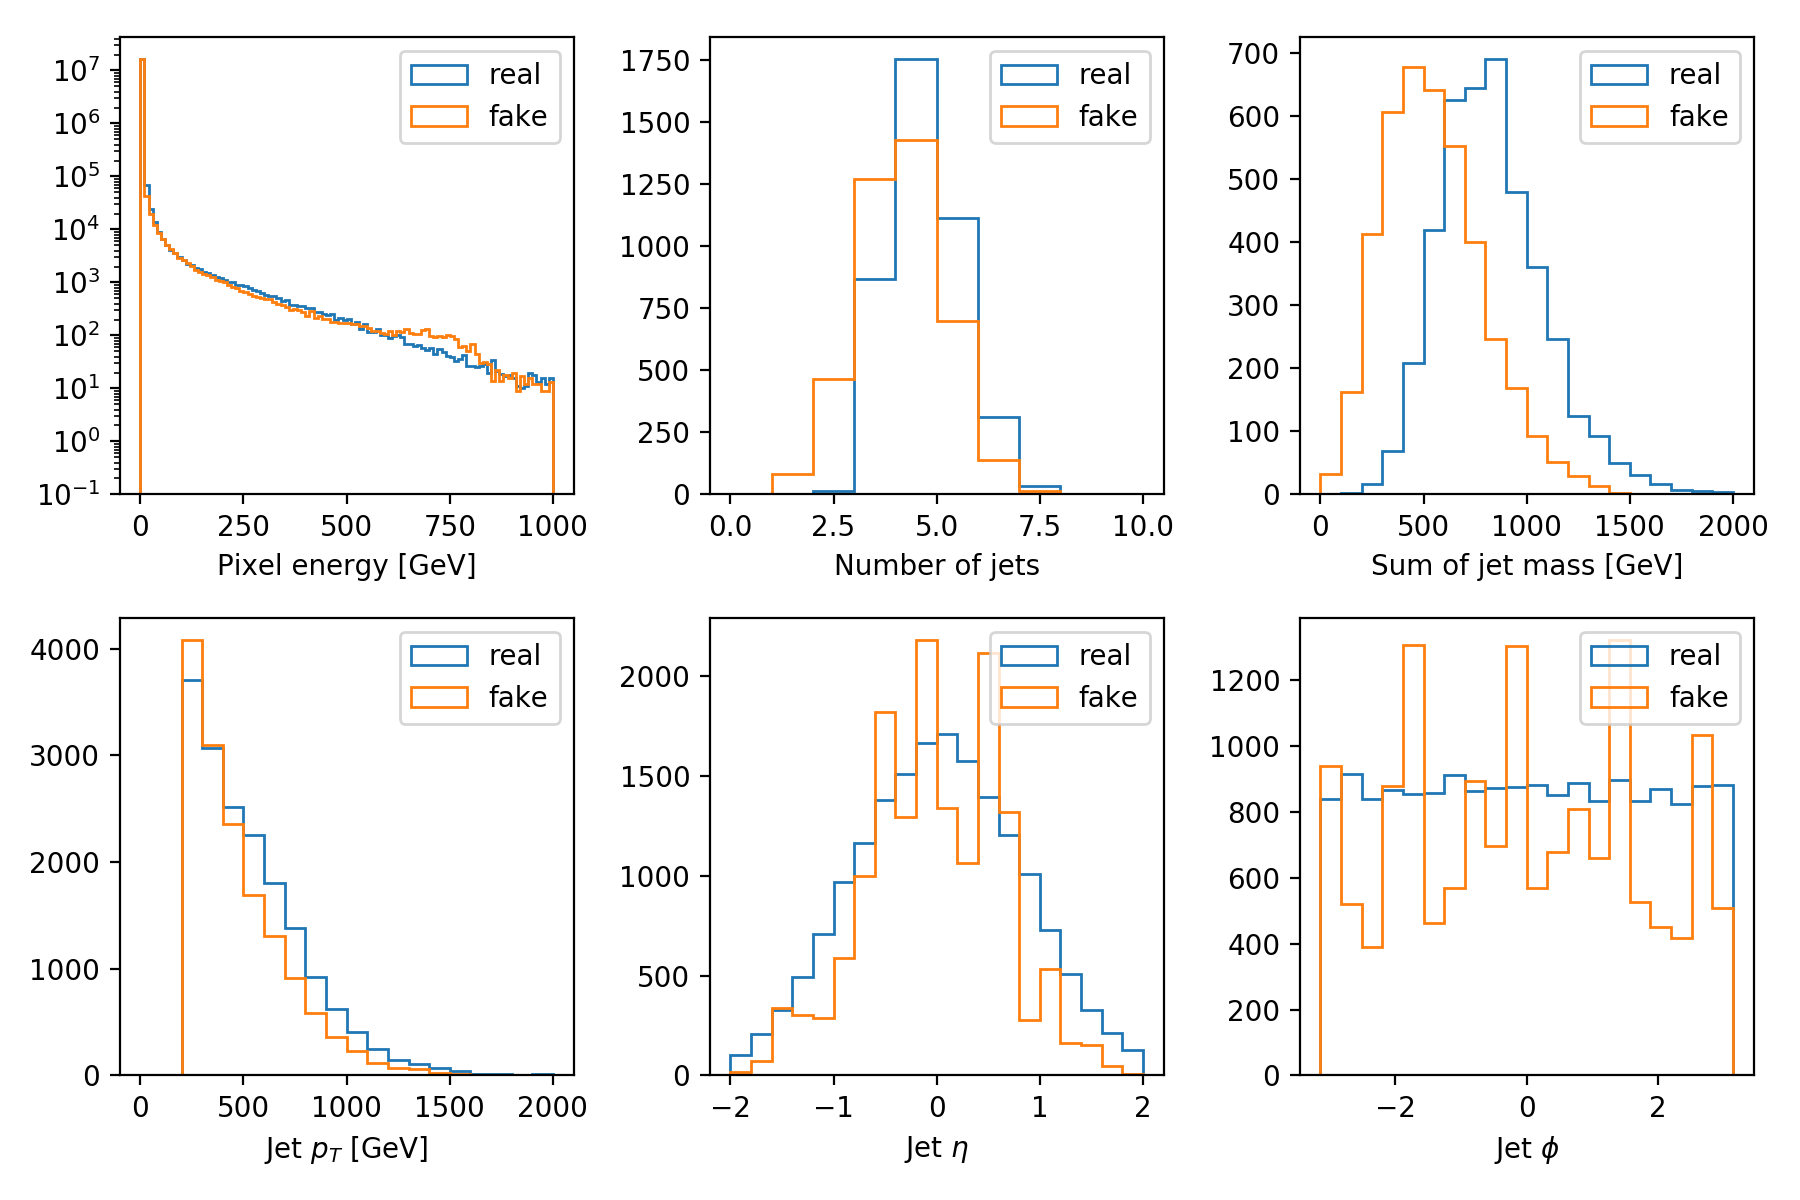

Epoch 15


<IPython.core.display.Javascript object>


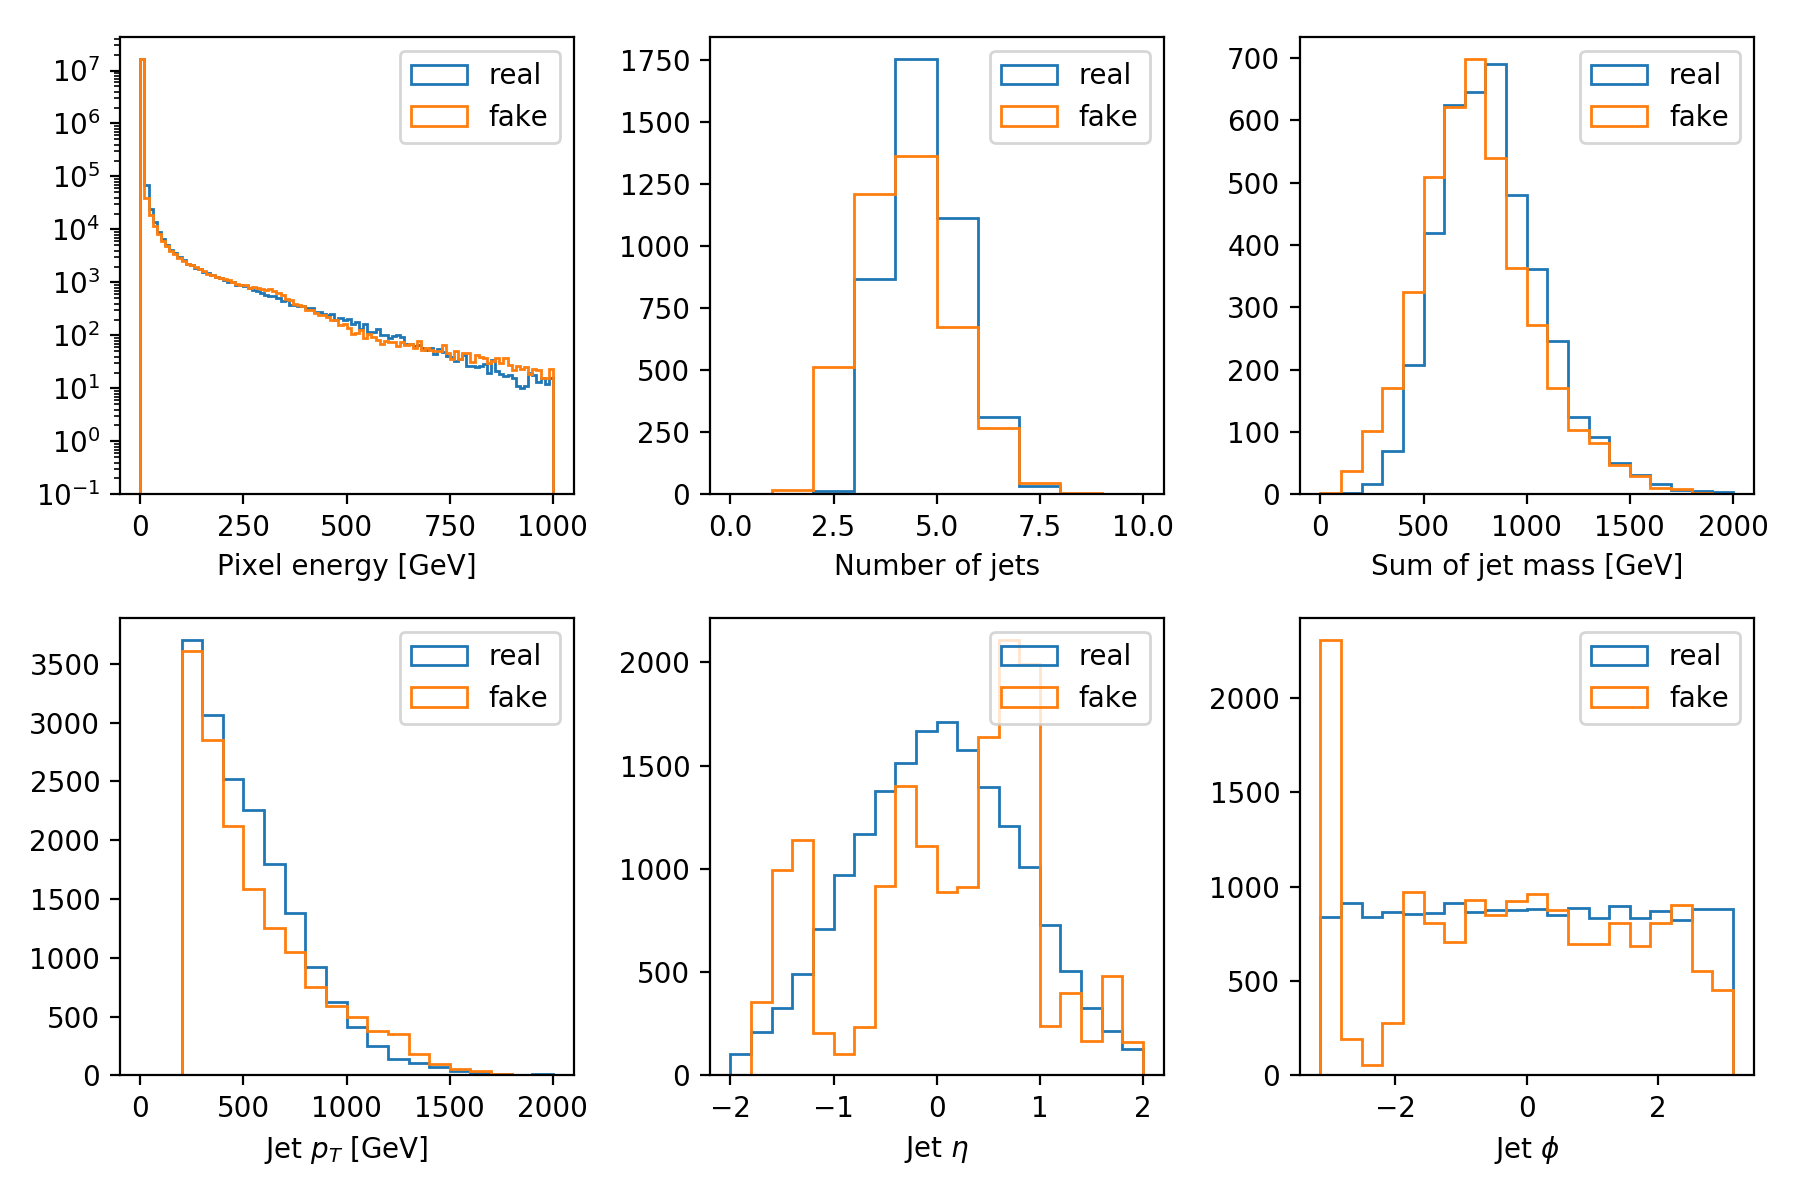

Epoch 31


<IPython.core.display.Javascript object>


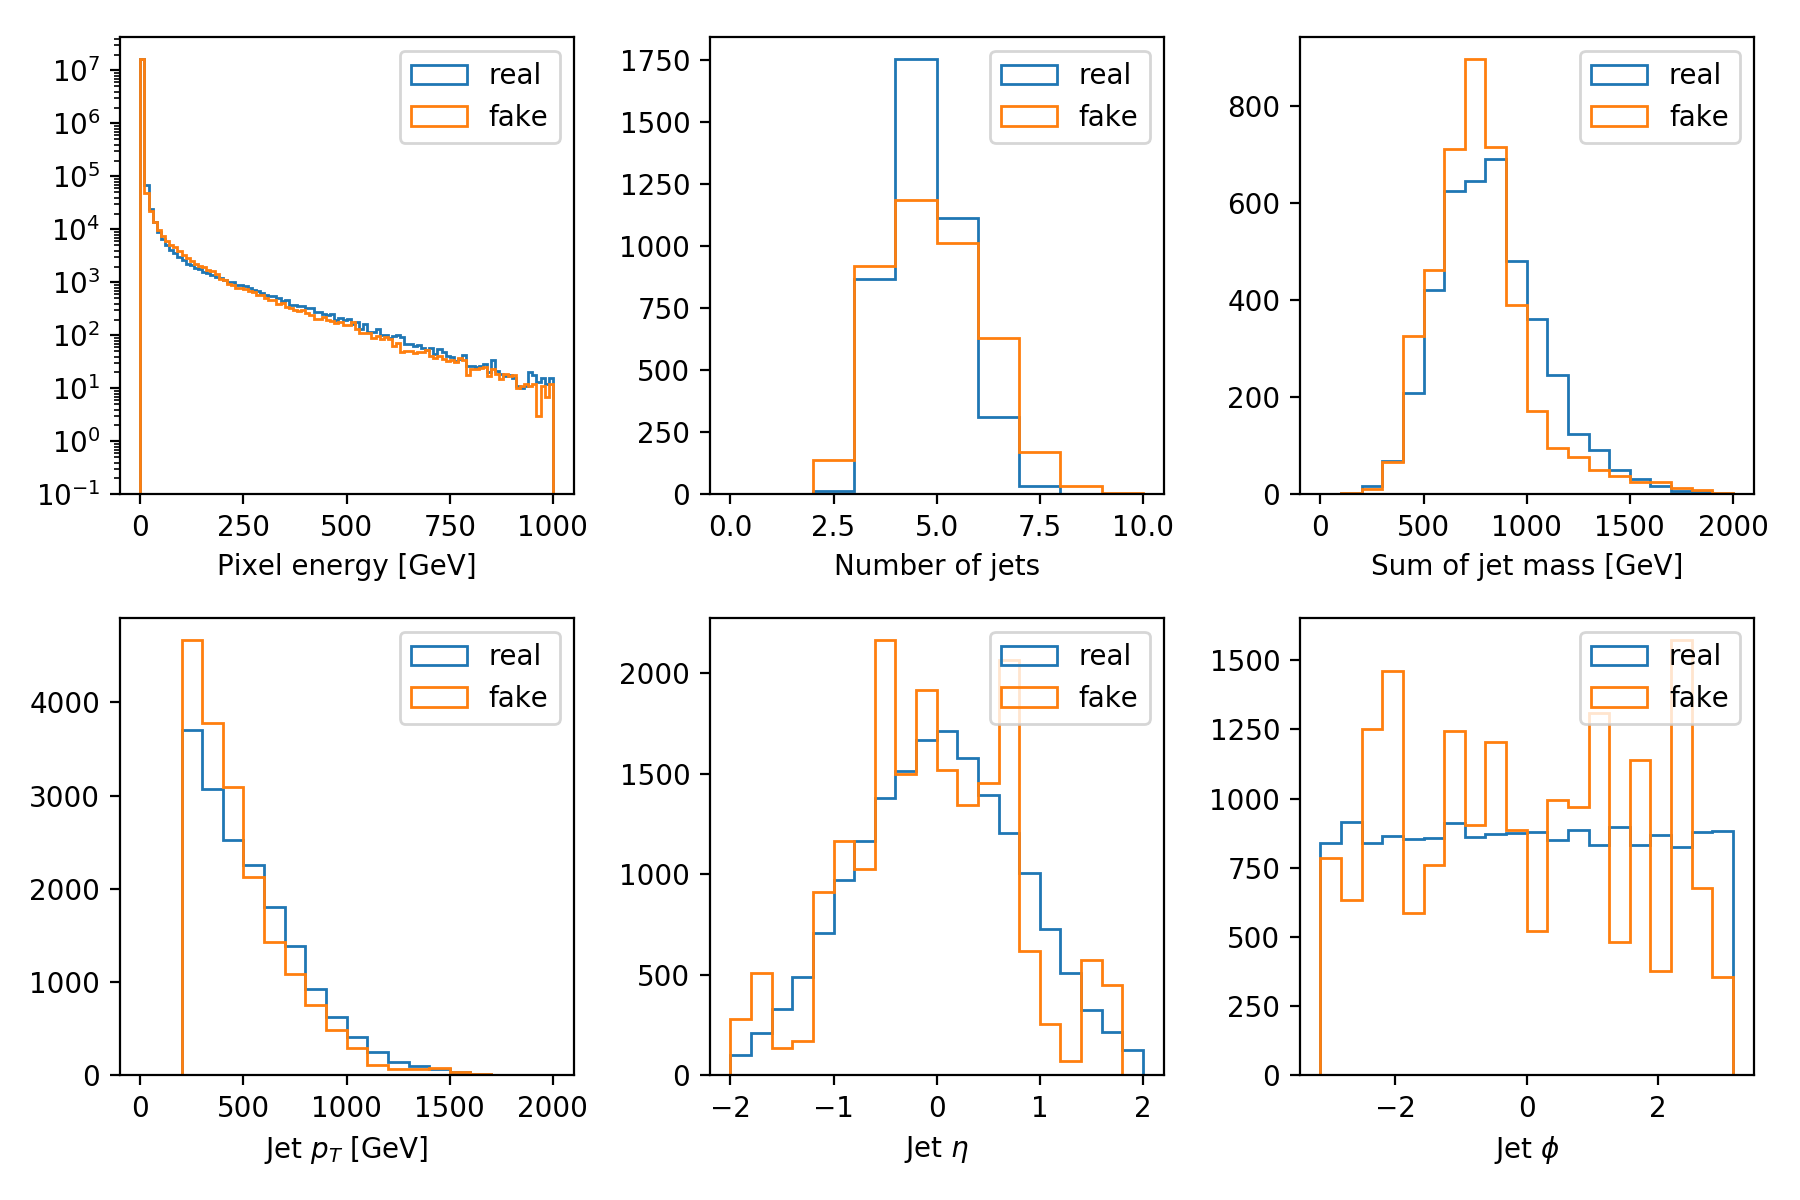

Epoch 41


<IPython.core.display.Javascript object>


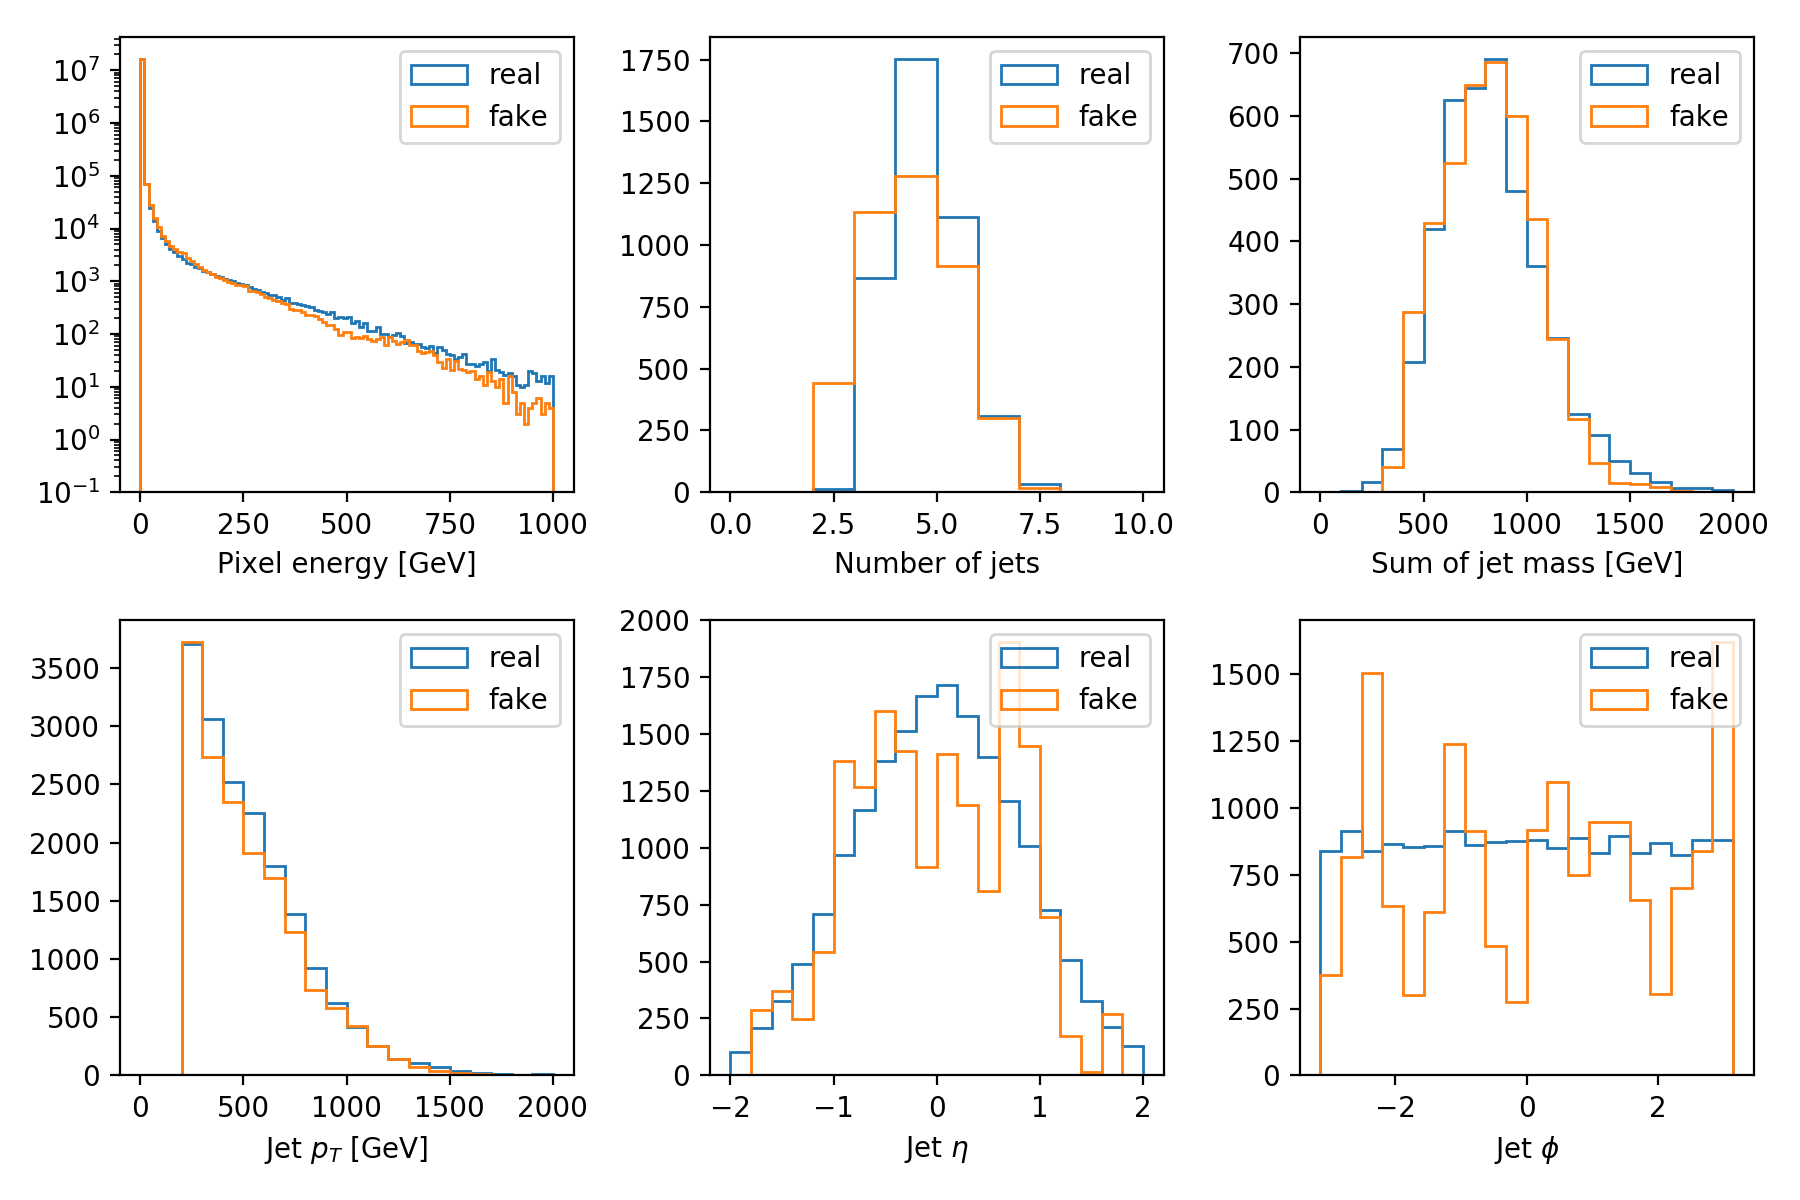

Epoch 63


<IPython.core.display.Javascript object>


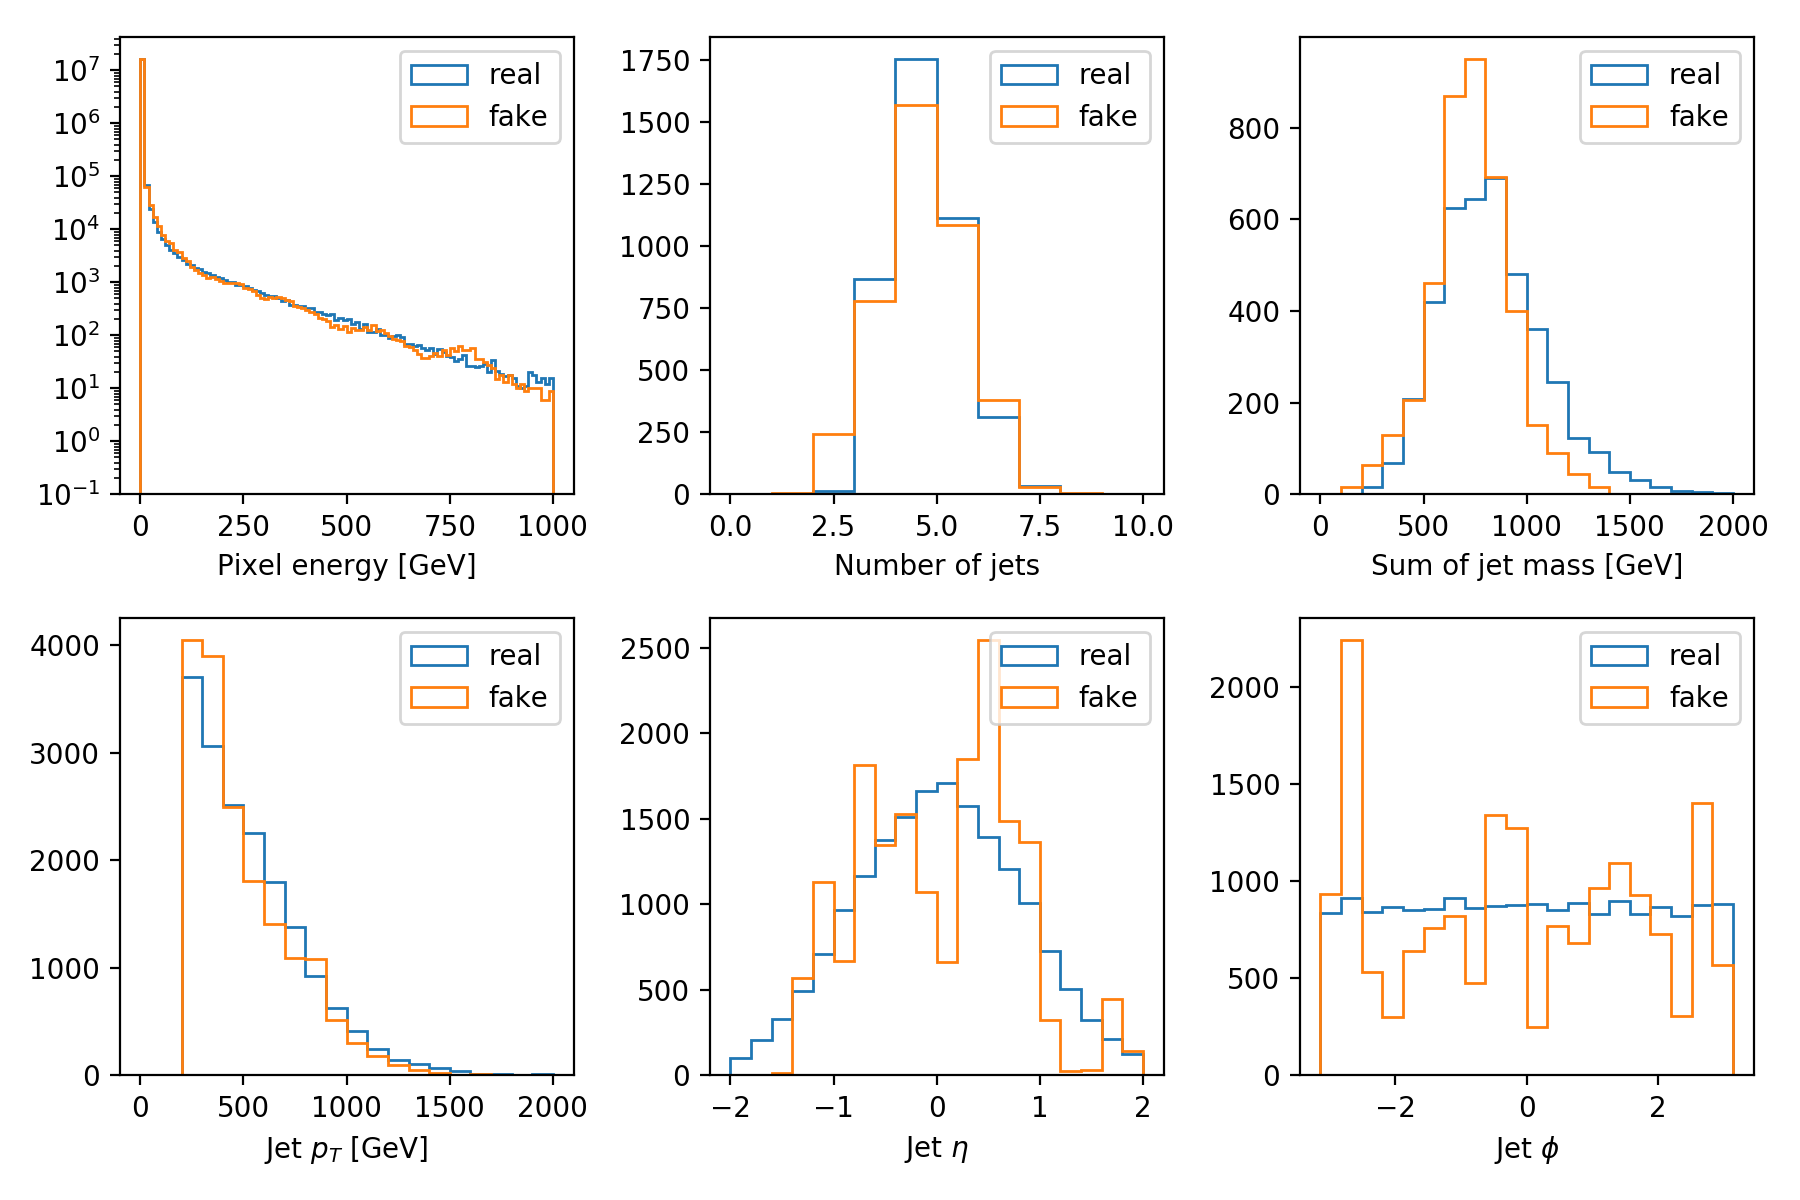

In [29]:
for i in [0, 1, 2, 7, 15, 31, 41, 63]:
    print('Epoch', i)
    plot_physics(test_images, final_results['gen_images'][i],
             real_reco_vars['nJet'], final_results['nJet'][i],
             real_reco_vars['sumMass'], final_results['sumMass'][i],
             real_reco_vars['jetPt'], final_results['jetPt'][i],
             real_reco_vars['jetEta'], final_results['jetEta'][i],
             real_reco_vars['jetPhi'], final_results['jetPhi'][i])

## Discussion